## Ventilator 데이터를 이용한 환자 exhale pressure 예측하기

Source : https://www.kaggle.com/competitions/ventilator-pressure-prediction

- 환자 호흡 압력 예측하기
- timeseries 데이터이고 inhale, exhale 모두 고려하기 위해 **Bidirectional LSTM**을 사용한다.

column information
- id: 고유한 시간 단계 식별자
- breath_id: 호흡에 대한 고유한 시간 단계
- R: **제어 변수**. 기도가 얼마나 제한되어 있는지를 나타내는 폐 속성(cmH2O/L/S 단위).R이 높을수록 기도가 제한되어있음
- C: **제어 변수**. 폐의 순응도를 나타내는 폐 속성(mL/cmH2O 단위). C가 높을수록 폐가 부풀기 쉬움.
- time_step: 타임스탬프
- u_in: 밸브 제어값으로 0부터 100까지
- u_out: 밸브 제어값으로 0 또는 1.
- pressure: **타겟변수**. 호흡 회로에서 측정된 기도 압력(cmH2O 단위)

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


### 1. 라이브러리 불러오기

In [2]:
# utils
import os
import warnings

# for data analysis
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

from tqdm.notebook import tqdm
from collections import Counter

warnings.filterwarnings("ignore")
small = True        # 작은 데이터로 학습할 것이다

### 2. 데이터 불러오기

In [3]:
base_path = "/content/drive/MyDrive/Colab Notebooks/data/ventilator-pressure-prediction/"

train = pd.read_csv(base_path + 'train.csv')
test = pd.read_csv(base_path + 'test.csv')

print(train.shape, test.shape)

(6036000, 8) (4024000, 7)


In [4]:
train.head()

,id,breath_id,R,C,time_step,u_in,u_out,pressure
0,1,1,20,50,0.000000,0.083334,0,5.837492
1,2,1,20,50,0.033652,18.383041,0,5.907794
2,3,1,20,50,0.067514,22.509278,0,7.876254
3,4,1,20,50,0.101542,22.808822,0,11.742872
4,5,1,20,50,0.135756,25.355850,0,12.234987


In [5]:
test.head()

,id,breath_id,R,C,time_step,u_in,u_out
0,1,0,5,20,0.000000,0.000000,0
1,2,0,5,20,0.031904,7.515046,0
2,3,0,5,20,0.063827,14.651675,0
3,4,0,5,20,0.095751,21.230610,0
4,5,0,5,20,0.127644,26.320956,0


In [8]:
# 실습을 위해 데이터 1% 정도로 샘플링한다.
if small:
  train = train[train['breath_id'] < 1000].reset_index(drop=True)
  display(train)

,id,breath_id,R,C,time_step,u_in,u_out,pressure
0,1,1,20,50,0.000000,0.083334,0,5.837492
1,2,1,20,50,0.033652,18.383041,0,5.907794
2,3,1,20,50,0.067514,22.509278,0,7.876254
3,4,1,20,50,0.101542,22.808822,0,11.742872
4,5,1,20,50,0.135756,25.355850,0,12.234987
...,...,...,...,...,...,...,...,...
50795,50796,999,50,50,2.386138,4.941322,1,6.610815
50796,50797,999,50,50,2.417893,4.949937,1,6.962326
50797,50798,999,50,50,2.449599,4.957276,1,7.102930
50798,50799,999,50,50,2.481339,4.963546,1,6.540513


- timeseries data이므로 sampling보다 slicing을 해야 한다.
- breath_id를 기준으로 1000개의 case만 가져온다.

### 3. EDA

In [9]:
def plot_sample(sample_id, df):
    df_breath = df[df['breath_id'] == sample_id]
    r, c  = df_breath[['R', 'C']].values[0]

    cols = ['u_in', 'u_out', 'pressure'] if 'pressure' in df.columns else ['u_in', 'u_out']
    
    plt.figure(figsize=(12, 4))
    for col in ['u_in', 'u_out', 'pressure']:
        plt.plot(df_breath['time_step'], df_breath[col], label=col)
        
    plt.legend()
    plt.title(f'breath_id: {sample_id} - R={r}, C={c}')

- 각 breath_id마다 timestemp에 따른 u_in, u_out과 pressure 출력

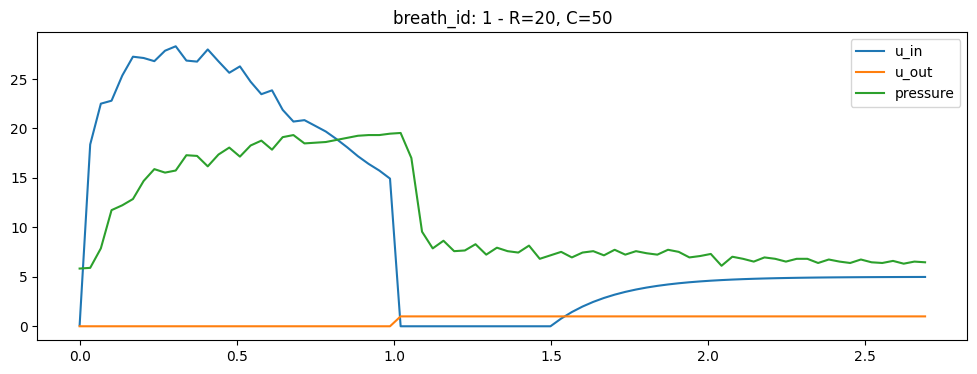

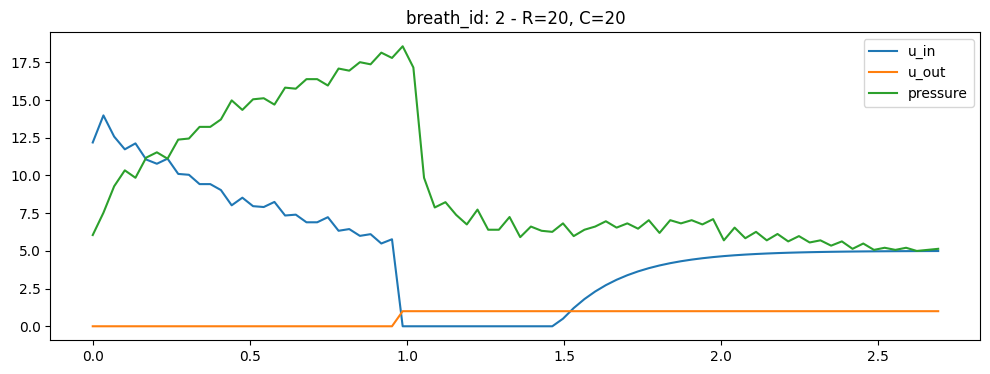

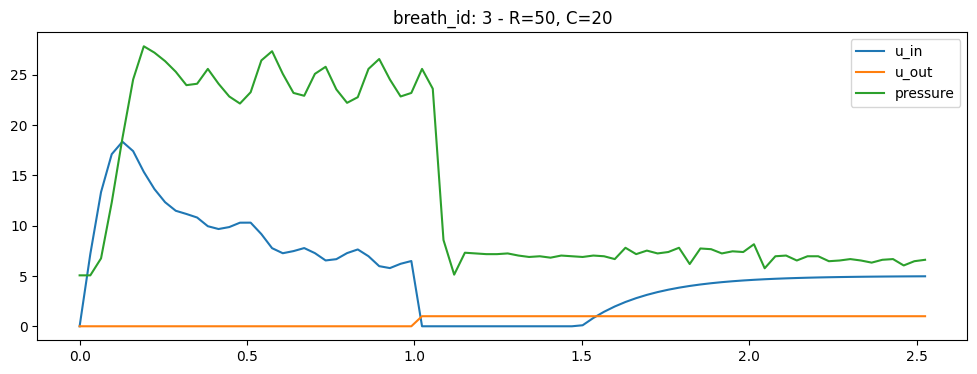

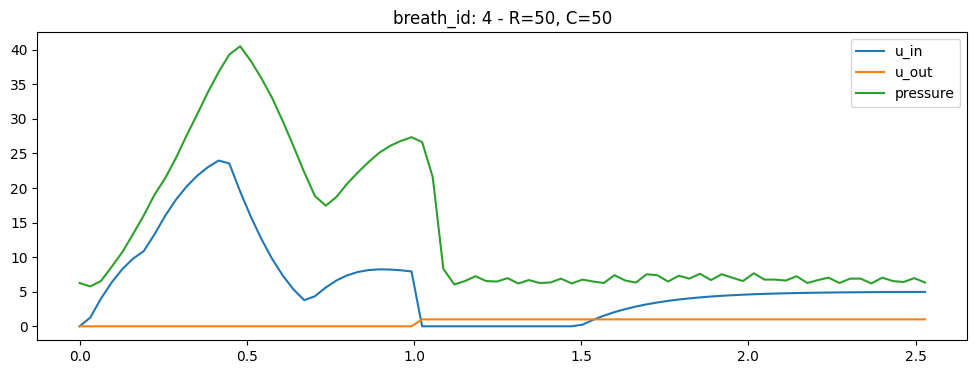

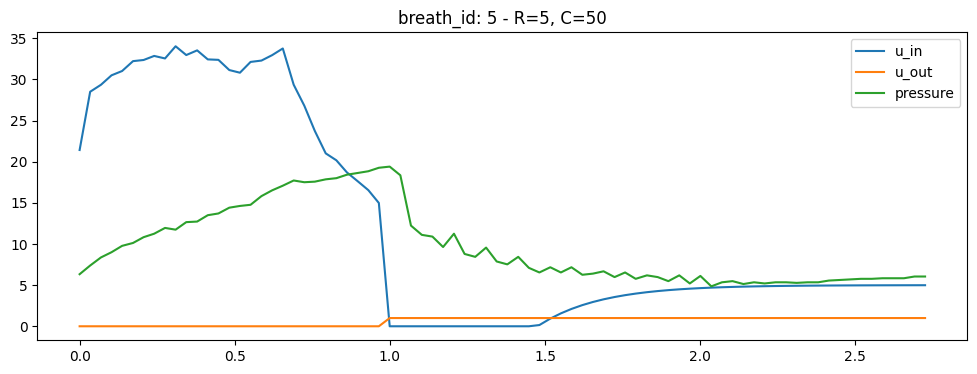

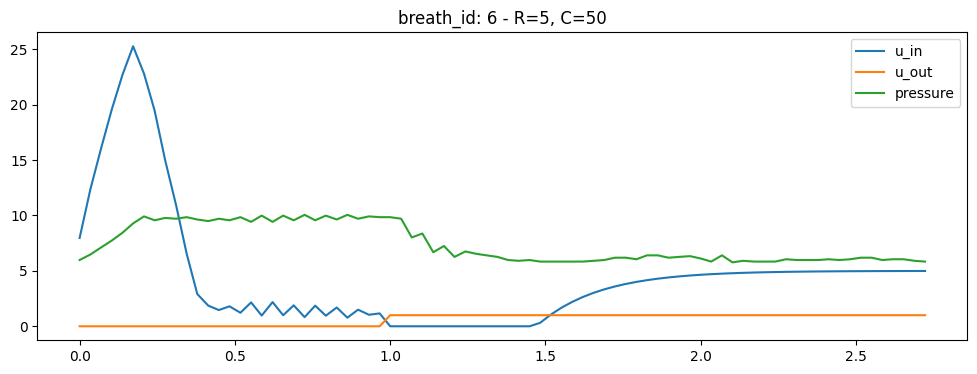

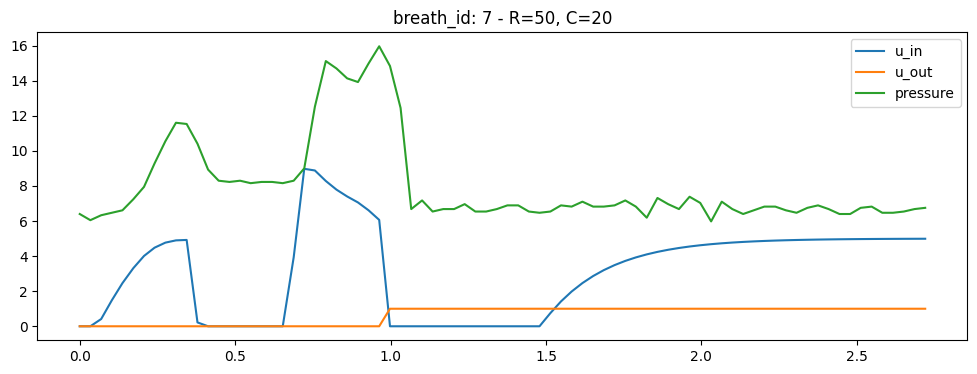

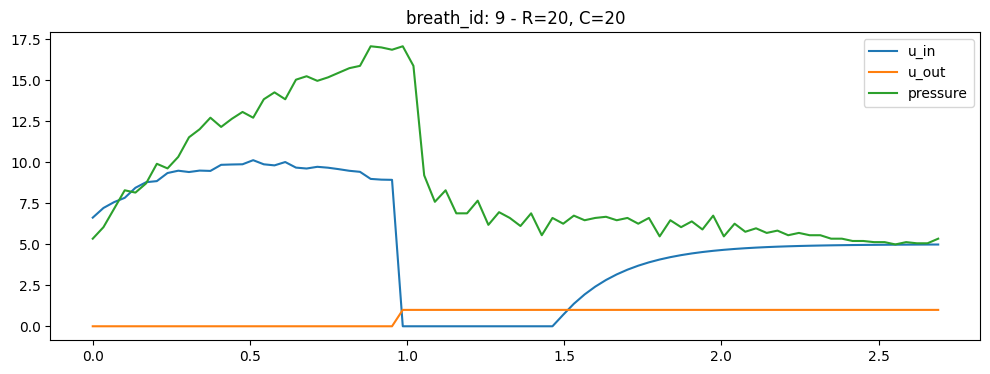

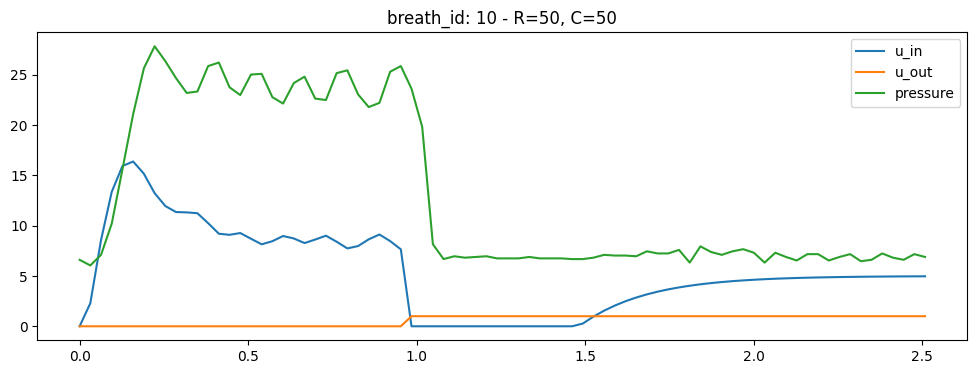

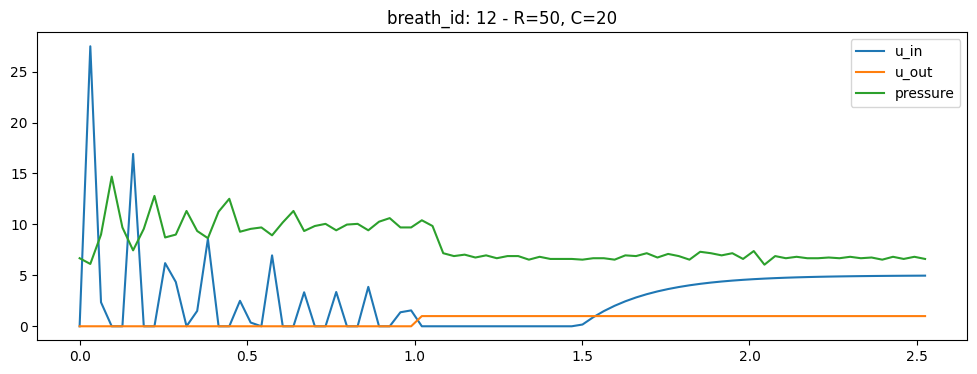

In [10]:
for i in train['breath_id'].unique()[:10]: # 10개만 출력해본다
    plot_sample(i, train)

- u_in과 pressure가 같은 추세를 보이기도, 완전히 다르기도 하는데 이는 R과 C의 값 때문이다.
- u_out이 0->1이 될 때 pressure가 크게 바뀌는 것을 볼 수 있다.

### 4. Sequential Modeling

- Data preparation

In [11]:
seq_len = 80      # hidden state 개수

y_train = train.pressure.to_numpy().reshape(-1, seq_len)
X_train = train.drop(columns=["pressure", "id", "breath_id"])
test = test.drop(columns=["id", "breath_id"])

In [12]:
from sklearn.preprocessing import RobustScaler
from sklearn.model_selection import train_test_split

scaler = RobustScaler()
X_train = scaler.fit_transform(X_train)
test = scaler.transform(test)

# reshaping
X_train = X_train.reshape(-1, seq_len, X_train.shape[-1])
test = test.reshape(-1, seq_len, test.shape[-1])

X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=0.2)
print(X_train.shape, X_val.shape, y_train.shape, y_val.shape)

(508, 80, 5) (127, 80, 5) (508, 80) (127, 80)


- x_train은 80(node 수)*5(feature 수)가 508개(input 데이터 개수) 있다

In [13]:
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Input, Bidirectional, LSTM, Dense

- tensorflow.keras.callbacks: learning rate를 조절하는 패키지
  - earlystopping: epoch를 기준으로 더이상 진전이 없을 때 자동으로 학습을 멈추는 방식
  - ReduceLROnPlateau: 변화가 없을 때 learning rate를 줄여서 더 자세히 학습하게 하는 방식

#### Model

- 4 Layers Bi-LSTM + FC layer
- Adam Optimizer
- ReduceLRonPlateau scheduler

In [14]:
# config variables
epochs = 200
batch_size = 1024
if small:
  epochs = 100
  batch_size = 128


scheduler = ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=10, min_lr=1e-5)

model = Sequential([
                    Input(shape=X_train.shape[1:]),
                    Bidirectional(LSTM(250, return_sequences=True)),
                    Bidirectional(LSTM(200, return_sequences=True)),
                    Bidirectional(LSTM(150, return_sequences=True)),
                    Bidirectional(LSTM(100, return_sequences=True)),
                    Dense(50, activation='relu'),
                    Dense(1) # output layer
])

model.compile(optimizer='adam', loss='mae')
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 bidirectional (Bidirectiona  (None, 80, 500)          512000    
 l)                                                              
                                                                 
 bidirectional_1 (Bidirectio  (None, 80, 400)          1121600   
 nal)                                                            
                                                                 
 bidirectional_2 (Bidirectio  (None, 80, 300)          661200    
 nal)                                                            
                                                                 
 bidirectional_3 (Bidirectio  (None, 80, 200)          320800    
 nal)                                                            
                                                                 
 dense (Dense)               (None, 80, 50)            1

-  ReduceLROnPlateau
  - monitor: 무엇을 기준으로 LR을 조정할 것인지 -> validation loss 기준
  - factor:LR을 줄일 때마다 얼마나 줄일 것인지 -> 0.5씩 곱한다
  - patience:몇 epoch를 기준으로 변화가 없는지 -> 10 epoch 기준
  - min_lr: 최소 lr -> 가장 최소값인 1e-5를 최소값으로 한다
- shape: (508, 80, 5)에서 첫번째를 뺀 (80, 5)
- return_sequences: 다음 학습에서 사용할 것인지

- 500 = 250*2(bidirectional)
- 400 = 200*2(bidirectional) ... 

#### Training

In [15]:
history = model.fit(X_train, y_train,
                    validation_data=(X_val, y_val),
                    epochs=epochs,
                    batch_size=batch_size,
                    callbacks=[scheduler],
                    verbose=1)

Epoch 1/100
4/4 [==============================] - 25s 2s/step - loss: 10.1882 - val_loss: 6.7097 - lr: 0.0010
Epoch 2/100
4/4 [==============================] - 1s 141ms/step - loss: 5.6326 - val_loss: 5.3836 - lr: 0.0010
Epoch 3/100
4/4 [==============================] - 0s 118ms/step - loss: 5.0602 - val_loss: 4.9708 - lr: 0.0010
Epoch 4/100
4/4 [==============================] - 0s 119ms/step - loss: 4.6565 - val_loss: 4.3622 - lr: 0.0010
Epoch 5/100
4/4 [==============================] - 0s 113ms/step - loss: 4.0443 - val_loss: 3.8525 - lr: 0.0010
Epoch 6/100
4/4 [==============================] - 1s 155ms/step - loss: 3.6400 - val_loss: 3.5714 - lr: 0.0010
Epoch 7/100
4/4 [==============================] - 1s 144ms/step - loss: 3.5689 - val_loss: 3.3069 - lr: 0.0010
Epoch 8/100
4/4 [==============================] - 1s 148ms/step - loss: 3.3850 - val_loss: 3.5672 - lr: 0.0010
Epoch 9/100
4/4 [==============================] - 1s 179ms/step - loss: 3.5106 - val_loss: 3.3751 - lr: 

### 5. Prediction

In [16]:
preds = model.predict(test).squeeze().reshape(-1, 1).squeeze()
preds

1572/1572 [==============================] - 29s 17ms/step


array([5.921899 , 6.2897396, 7.1574664, ..., 6.310055 , 6.2757483,
       6.277959 ], dtype=float32)

In [17]:
submission = pd.read_csv(base_path + "sample_submission.csv")
submission

,id,pressure
0,1,0
1,2,0
2,3,0
3,4,0
4,5,0
...,...,...
4023995,4023996,0
4023996,4023997,0
4023997,4023998,0
4023998,4023999,0


In [18]:
submission['pressure'] = preds
output_path = "submission_full.csv"
if small:
  output_path = "submission_small.csv"
submission.to_csv(output_path, index=False)